In [1]:
import jax
import jax.numpy as jnp

import numpy as np
from tqdm.auto import tqdm
import pickle

from mpc4px4.modelling.train_static_model import load_vector_field_from_file, init_data

%matplotlib widget
import matplotlib.pyplot as plt

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

In [2]:
# Utility functions
def load_training_data(log_prefix, motor_models):
    """Load the training data from the log files

    Args:
        log_prefix (str): The prefix of the log files
        motor_models (List): The motor models used for training

    Returns:
        dict: The training data
    """
    dict_data = {}
    for motor_model in motor_models:
        log_file = log_prefix + motor_model + '.pkl'
        with open(log_file, 'rb') as f:
            my_data = pickle.load(f)
            dict_data[motor_model] = {'params_evol' : my_data['parameter_evolution'], 
                                     'logs' : my_data['log_data'], 
                                     'opt_params' : my_data['best_params']}
        # Load the data using pickle
    return dict_data

def load_quad_dynamics_fn(log_prefix, motor_models):
    """Load the quad dynamics function from the log files

    Args:
        log_prefix (str): The prefix of the log files
        motor_models (List): The motor models used for training

    Returns:
        dict: The quad dynamics function
    """
    dict_data = {}
    for motor_model in motor_models:
        log_file = log_prefix + motor_model + '_learned_params.yaml'
        vehicle_dict, (vector_field_pred, motor_model_fn, body_moment_from_actuator, body_thrust_from_actuator) = load_vector_field_from_file(log_file)
        dict_data[motor_model] = {'vector_field_pred' : vector_field_pred, 
                                    'motor_model_fn' : motor_model_fn,
                                    'body_moment_from_actuator' : body_moment_from_actuator, 
                                    'body_thrust_from_actuator' : body_thrust_from_actuator,
                                    'vehicle_dict' : vehicle_dict
                                }
    return dict_data

In [3]:
# Define the logs data file
log_prefix = 'learned_models/test_'
motor_models = ['linear', 'quadratic', 'cubic', 'sigmoid_quad', 'crazy', 'fourrier']
dict_data = load_training_data(log_prefix, motor_models)
dict_quad_dynamics = load_quad_dynamics_fn(log_prefix, motor_models)

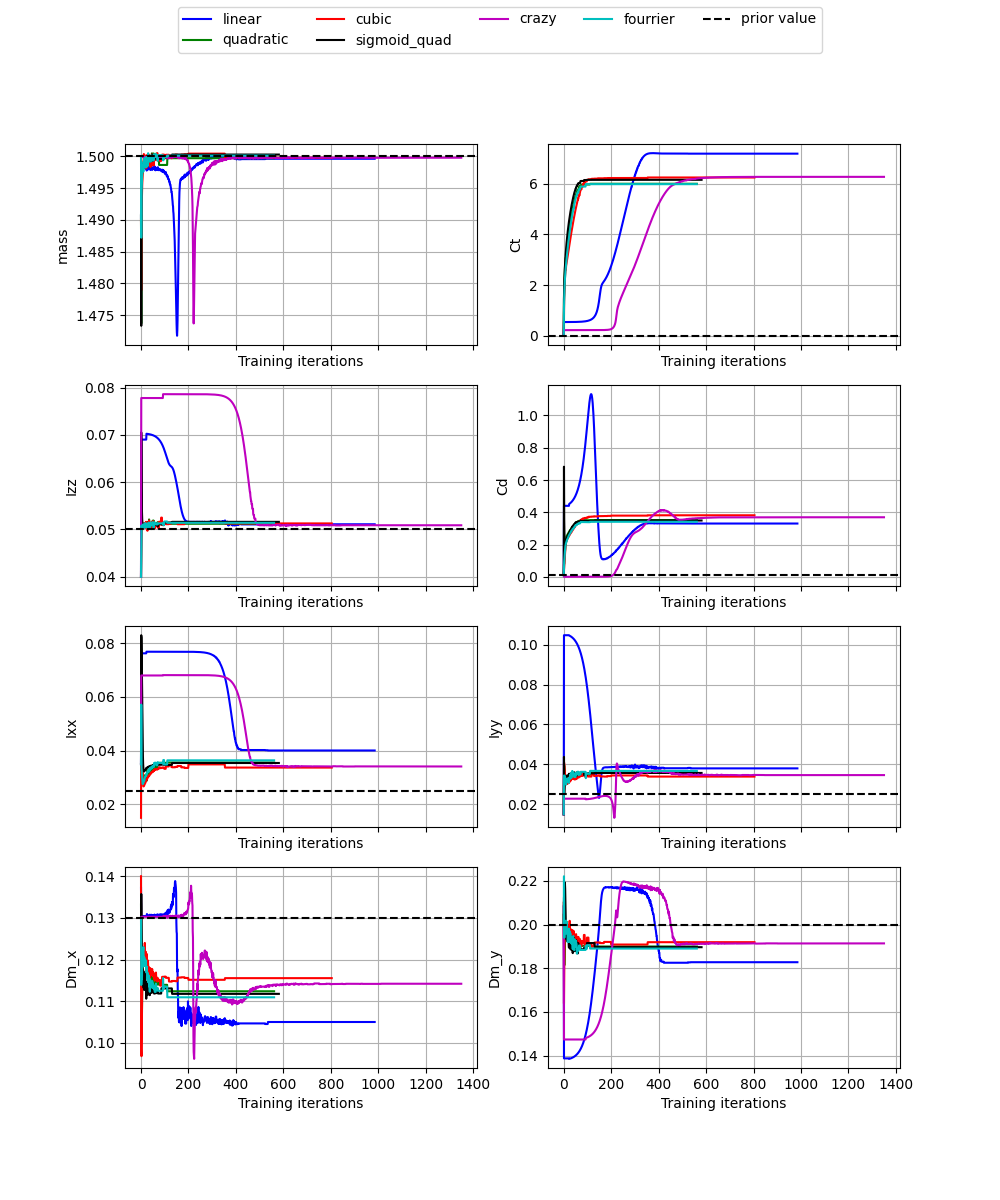

In [4]:
# dict_data[motor_models[0]]['params_evol']
color_motor_models = {'linear' : 'b', 'quadratic' : 'g', 'cubic' : 'r', 'sigmoid_quad' : 'k', 'crazy' : 'm', 'fourrier' : 'c'}
list_keys_to_plot = ['mass', 'Ct', 'Izz', 'Cd', 'Ixx', 'Iyy', 'Dm_x', 'Dm_y']

# Create subplots for parameters evolution
fig, axs = plt.subplots(4, 2, figsize=(10, 12), sharex=True)
axs = axs.flatten()
for motor_model in motor_models:
    evol_params = dict_data[motor_model]['params_evol']
    # Each elem in evol_params is a dict with keys parameters and value
    evol_params = {k : np.array([elem['quad_dynamics'][k] for elem in evol_params]) for k in list_keys_to_plot }
    for i, (k, v) in enumerate(evol_params.items()):
        # Plot the evolution of the parameters
        axs[i].plot(v, color=color_motor_models[motor_model], label=motor_model)
        # Set the y axis
        axs[i].set_ylabel(k)
        axs[i].set_xlabel('Training iterations')

# Add the prior value for all these parameters
prior_dict = dict_quad_dynamics[motor_models[0]]['vehicle_dict']['prior']
for i, k in enumerate(list_keys_to_plot):
    axs[i].axhline(prior_dict[k], color='k', linestyle='--', label='prior value')

# Set the grid
for ax in axs:
    ax.grid()

# Set a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)



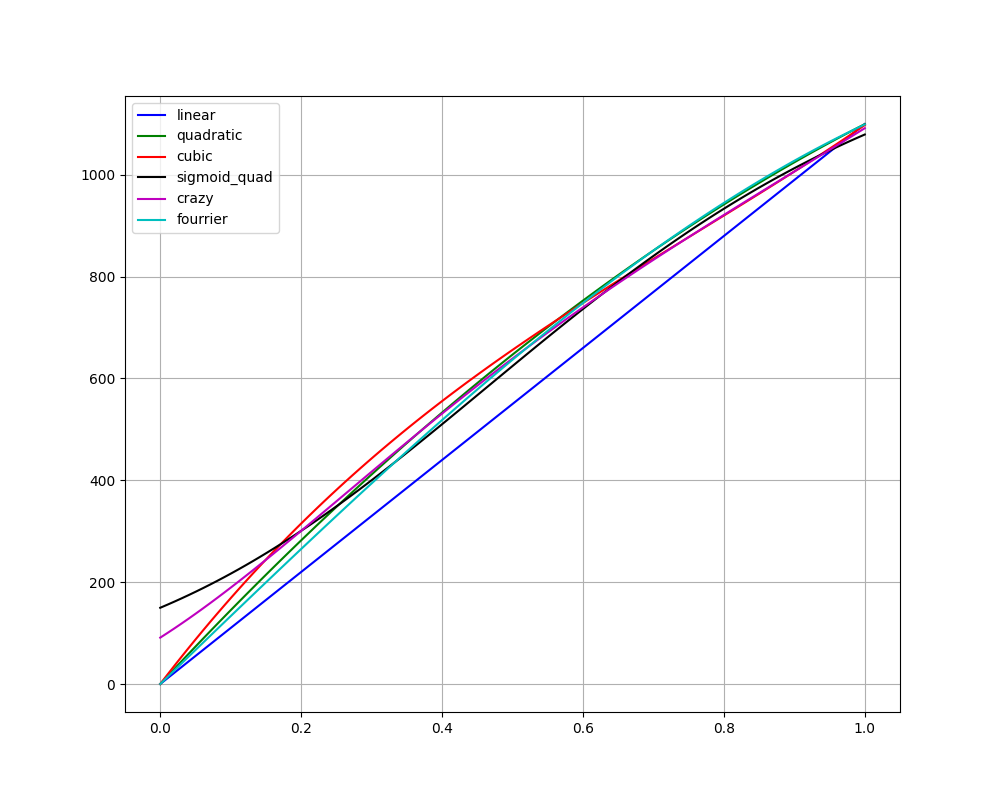

In [5]:
# Now let's compare the learned motor models
pwm_range = np.linspace(0, 1., 100)
# Single figure to compare the model
fig = plt.figure(figsize=(10, 8))
for motor_model in motor_models:
    motor_model_fn = dict_quad_dynamics[motor_model]['motor_model_fn']
    plt.plot(pwm_range, motor_model_fn(pwm_range), color=color_motor_models[motor_model], label=motor_model)
plt.grid()
plt.legend()


In [6]:
# Define the cuttoff frequence based on the data
# This will only be used if the data hasn't be filtered already
cutoff_freqs = {'x' : 2., 'y' : 2., 'z' : 2., 'vx' : 4.,
                'vy' : 4, 'vz' : 4, 'qw' : 6,
                'qx' : 6, 'qy' : 6, 'qz' : 6, 'wx' : 6,
                'wy' : 6, 'wz' : 6, 'm1' : 2, 'm2' : 2,
                'm3' : 2, 'm4' : 2,
}

test_data_file = '/home/franckdjeumou/Documents/log_flights/log_6_2022-10-25-14-03-16.ulg'
# Load the filered data
data_test = init_data(test_data_file, cutoff_freqs=cutoff_freqs, force_filtering=False)

Data loaded from filtered file


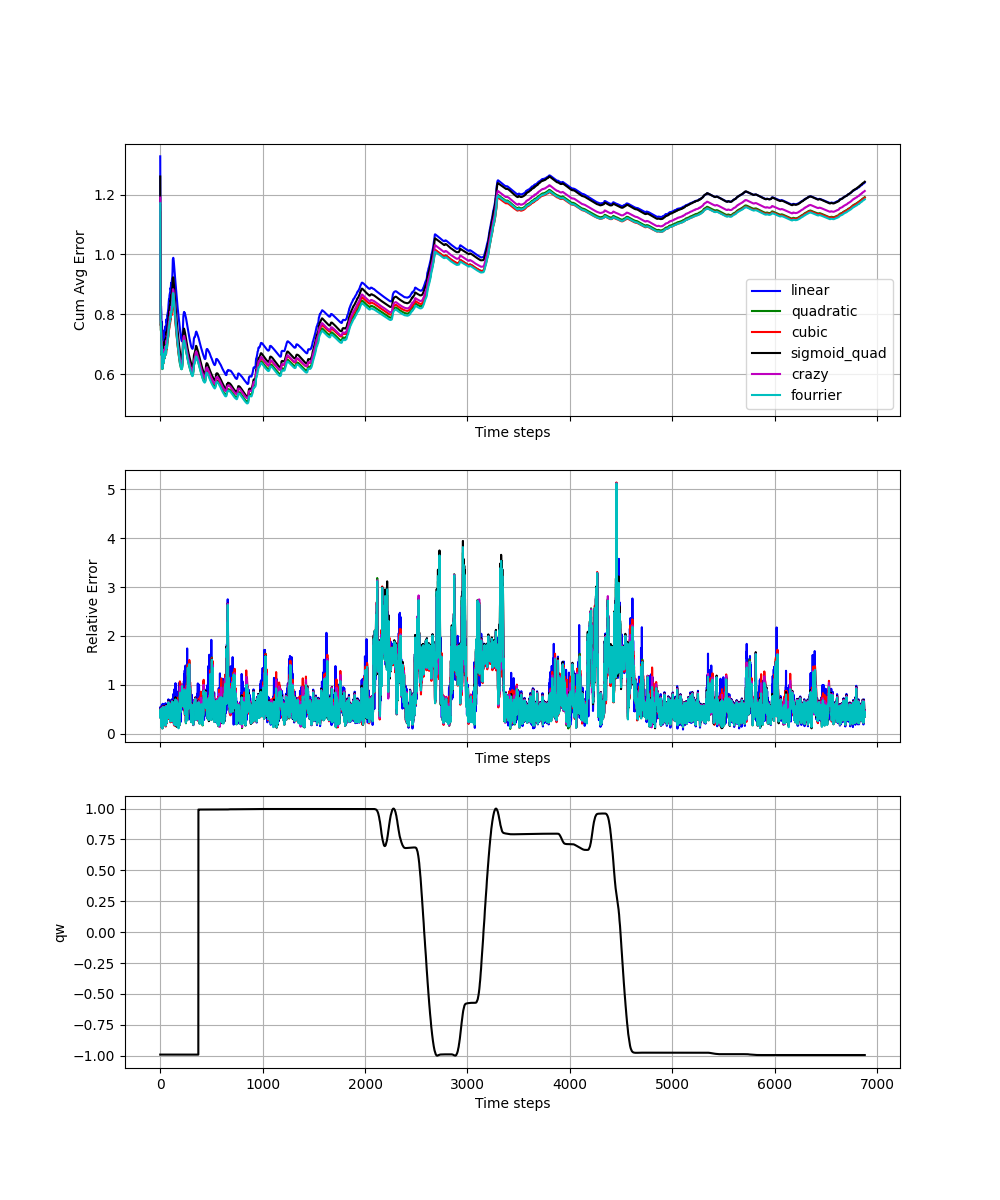

In [7]:
# Let's compare the prediction of the vector field
# We are going to do it over the trajectory of the quadrotor
# We will plot the error between the predicted and the xdot in the trajectory
# Plot also z on a subplot
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
axs = axs.flatten()
for motor_model in motor_models:
    # Get the vector field function
    vector_field_pred = dict_quad_dynamics[motor_model]['vector_field_pred']
    # Get the trajectory
    trajectory = data_test
    # Get the xdot and only keep vx, vy, vz, wx, wy, wz
    indx_interest = [3, 4, 5, 10, 11, 12]
    # indx_interest = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    xdot = trajectory['x_dot'][:,indx_interest]
    # xdot = trajectory['x_dot']
    # Get the prediction
    xdot_pred = jax.vmap(vector_field_pred)(trajectory['x'], trajectory['u'])[:,indx_interest]
    # Compute the error
    cum_error = np.linalg.norm(xdot - xdot_pred, axis=1)
    # Compute a geometric relative error
    cum_error_rel = np.linalg.norm(xdot - xdot_pred, axis=1) / np.linalg.norm(xdot, axis=1)
    cum_error_rel  = np.cumsum(cum_error_rel) / np.arange(1, len(cum_error_rel) + 1)
    # COmpute the cumulative error
    # cum_error = np.cumsum(error)
    # Plot the error
    axs[0].plot(cum_error_rel, color=color_motor_models[motor_model], label=motor_model)
    axs[1].plot(cum_error, color=color_motor_models[motor_model], label=motor_model)
axs[2].plot(trajectory['x'][:, 6], color='k', label='z')

axs[0].set_ylabel('Cum Avg Error')
axs[1].set_ylabel('Relative Error')
axs[2].set_ylabel('qw')

axs[0].set_xlabel('Time steps')
axs[1].set_xlabel('Time steps')
axs[2].set_xlabel('Time steps')

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[0].legend()

In [ ]:
# Define the cuttoff frequence based on the data
# This will only be used if the data hasn't be filtered already
cutoff_freqs = {'x' : 2., 'y' : 2., 'z' : 2., 'vx' : 4.,
                'vy' : 4, 'vz' : 4, 'qw' : 6,
                'qx' : 6, 'qy' : 6, 'qz' : 6, 'wx' : 6,
                'wy' : 6, 'wz' : 6, 'm1' : 2, 'm2' : 2,
                'm3' : 2, 'm4' : 2,
}

test_data_file = '/home/franckdjeumou/Documents/log_flights/log_6_2022-10-25-14-03-16.ulg'
# Load the filered data
data_test = init_data(test_data_file, cutoff_freqs=cutoff_freqs, force_filtering=False)